Saving camera_man.png to camera_man (1).png


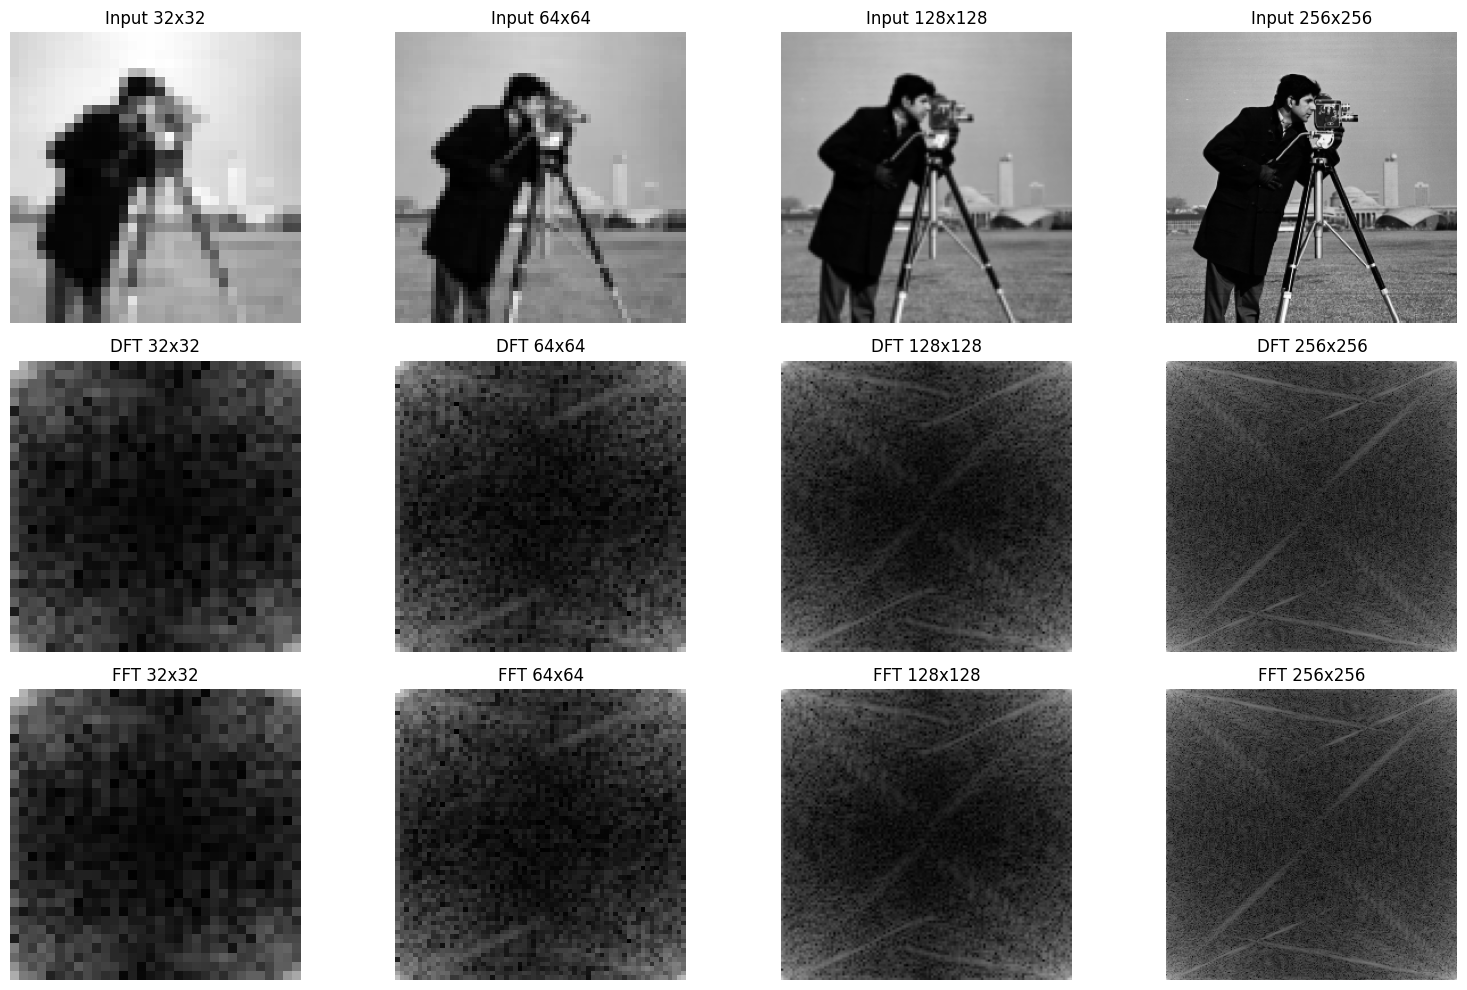

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from google.colab import files


uploaded = files.upload()              # choose any image file
IMAGE_PATH = next(iter(uploaded))      # first uploaded file name


# ============================
# 1D DFT (from scratch)
# ============================
def dft1d(x):
    """
    Naive 1D DFT: O(N^2)
    x: 1D numpy array (real or complex)
    """
    x = np.asarray(x, dtype=complex)
    N = x.shape[0]
    X = np.zeros(N, dtype=complex)
    for k in range(N):
        s = 0+0j
        for n in range(N):
            s += x[n] * np.exp(-2j * np.pi * k * n / N)
        X[k] = s
    return X

# ============================
# 1D FFT (radix-2, from scratch)
# ============================
def fft1d(x):
    """
    Radix-2 Cooley–Tukey FFT: O(N log N)
    Length of x must be a power of 2.
    """
    x = np.asarray(x, dtype=complex)
    N = x.shape[0]

    if N == 1:
        return x.copy()

    # power-of-two check
    if N & (N - 1) != 0:
        raise ValueError("Length of input must be a power of 2 for this FFT implementation.")

    # even & odd
    X_even = fft1d(x[0::2])
    X_odd  = fft1d(x[1::2])

    factor = np.exp(-2j * np.pi * np.arange(N) / N)

    X = np.zeros(N, dtype=complex)
    half = N // 2
    for k in range(half):
        t = factor[k] * X_odd[k]
        X[k]        = X_even[k] + t
        X[k + half] = X_even[k] - t
    return X


# ============================
# 2D DFT using 1D DFT
# ============================
def dft2d(img):
    """
    2D DFT: apply 1D DFT on rows, then on columns.
    img: 2D numpy array
    """
    img = np.asarray(img, dtype=complex)
    M, N = img.shape

    # rows
    temp = np.zeros((M, N), dtype=complex)
    for i in range(M):
        temp[i, :] = dft1d(img[i, :])

    # columns
    out = np.zeros((M, N), dtype=complex)
    for j in range(N):
        out[:, j] = dft1d(temp[:, j])

    return out

# ============================
# 2D FFT using 1D FFT
# ============================
def fft2d(img):
    """
    2D FFT: apply 1D FFT on rows, then on columns.
    Both M, N must be powers of 2.
    """
    img = np.asarray(img, dtype=complex)
    M, N = img.shape

    if (M & (M - 1)) != 0 or (N & (N - 1)) != 0:
        raise ValueError("Both dimensions must be powers of 2 for this FFT implementation.")

    # rows
    temp = np.zeros((M, N), dtype=complex)
    for i in range(M):
        temp[i, :] = fft1d(img[i, :])

    # columns
    out = np.zeros((M, N), dtype=complex)
    for j in range(N):
        out[:, j] = fft1d(temp[:, j])

    return out


# ===== MAIN: one image, 4 sizes, input + DFT + FFT plot =====

# 4 different sizes (all power-of-two, FFT friendly)
sizes = [32, 64, 128, 256]

# Original image load, grayscale
img_orig = Image.open(IMAGE_PATH).convert("L")

resized_imgs = []   # <-- resized input images store korbo
dft_results = []
fft_results = []

for s in sizes:
    # one image → 4 sizes
    img_resized = img_orig.resize((s, s), Image.BILINEAR)
    arr = np.asarray(img_resized, dtype=float) / 255.0  # normalize [0,1]

    resized_imgs.append(arr)          # <-- store input image

    # 2D DFT & 2D FFT (scratch)
    dft_res = dft2d(arr)
    fft_res = fft2d(arr)

    dft_results.append(dft_res)
    fft_results.append(fft_res)

# Row 1: input images
# Row 2: DFT magnitude
# Row 3: FFT magnitude
fig, axes = plt.subplots(3, 4, figsize=(16, 10))

for idx, s in enumerate(sizes):
    # ---- Input image (resized) ----
    axes[0, idx].imshow(resized_imgs[idx], cmap="gray")
    axes[0, idx].set_title(f"Input {s}x{s}")
    axes[0, idx].axis("off")

    # ---- DFT magnitude spectrum ----
    mag_dft = np.log1p(np.abs(dft_results[idx]))
    axes[1, idx].imshow(mag_dft, cmap="gray")
    axes[1, idx].set_title(f"DFT {s}x{s}")
    axes[1, idx].axis("off")

    # ---- FFT magnitude spectrum ----
    mag_fft = np.log1p(np.abs(fft_results[idx]))
    axes[2, idx].imshow(mag_fft, cmap="gray")
    axes[2, idx].set_title(f"FFT {s}x{s}")
    axes[2, idx].axis("off")

plt.tight_layout()
plt.show()
